In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import copy
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

To build your neural network, we'll be implementing several "helper functions." These helper functions will be used in a implementation aftwards.

- Initialize the parameters for an $L$-layer neural network
- Implement the forward propagation module (shown in purple in the figure below)
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$).
     - The ACTIVATION function is provided for you (relu/sigmoid)
     - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives you a new L_model_forward function.
- Compute the loss
- Implement the backward propagation module (denoted in red in the figure below)
    - Complete the LINEAR part of a layer's backward propagation step
    - The gradient of the ACTIVATION function is provided for you(relu_backward/sigmoid_backward) 
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally, update the parameters

<img src="images/final outline.png" style="width:800px;height:500px;">
<caption><center><b>Figure 1</b></center></caption><br>

For every forward function, there is a corresponding backward function. This is why at every step from the forward module we will be storing some values in a cache. These cached values are useful for computing gradients. In the backpropagation module, the cache is used to calculate the gradients.

## Initialization

We will use [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html) and [np.zeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html).

### L-layer Neural Network

The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_parameters_deep` function, you should make sure that your dimensions match between each layer. Recall that $n^{[l]}$ is the number of units in layer $l$. For example, if the size of your input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

<table style="width:100%">
    <tr>
        <td>  </td> 
        <td> <b>Shape of W</b> </td> 
        <td> <b>Shape of b</b>  </td> 
        <td> <b>Activation</b> </td>
        <td> <b>Shape of Activation</b> </td> 
    <tr>
    <tr>
        <td> <b>Layer 1</b> </td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},209)$ </td> 
    <tr>
    <tr>
        <td> <b>Layer 2</b> </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>  
   <tr>
       <td> <b>Layer L-1</b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
   <tr>
   <tr>
       <td> <b>Layer L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>
</table>

Remember that when you compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    w_{00}  & w_{01} & w_{02} \\
    w_{10}  & w_{11} & w_{12} \\
    w_{20}  & w_{21} & w_{22} 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    x_{00}  & x_{01} & x_{02} \\
    x_{10}  & x_{11} & x_{12} \\
    x_{20}  & x_{21} & x_{22} 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    b_0  \\
    b_1  \\
    b_2
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (w_{00}x_{00} + w_{01}x_{10} + w_{02}x_{20}) + b_0 & (w_{00}x_{01} + w_{01}x_{11} + w_{02}x_{21}) + b_0 & \cdots \\
    (w_{10}x_{00} + w_{11}x_{10} + w_{12}x_{20}) + b_1 & (w_{10}x_{01} + w_{11}x_{11} + w_{12}x_{21}) + b_1 & \cdots \\
    (w_{20}x_{00} + w_{21}x_{10} + w_{22}x_{20}) + b_2 &  (w_{20}x_{01} + w_{21}x_{11} + w_{22}x_{21}) + b_2 & \cdots
\end{bmatrix}\tag{3}  $$


In [2]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims) # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

## Forward Propagation Module

<a name='4-1'></a>
### 4.1 - Linear Forward 

Now that you have initialized your parameters, you can do the forward propagation module. Start by implementing some basic functions that you can use again later when implementing the model. Now, you'll complete three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

**Reminder**:
The mathematical representation of this unit is $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$. You may also find `np.dot()` useful. If your dimensions don't match, printing `W.shape` may help.

In [3]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b"; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    
    cache = (A, W, b)
    
    return Z, cache

### Linear-Activation Forward

We will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. You've been provided with the `sigmoid` function which returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. You've been provided with the `relu` function. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what you'll feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

For added convenience, you're going to group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION). Hence, you'll implement a function that does the LINEAR forward step, followed by an ACTIVATION forward step.


In [4]:
def sigmoid(Z):
    """
    Implement the sigmoid activation function.

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache


def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0, Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache



def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    else:
        print("\033[91mError! Please make sure you have passed the value correctly in the \"activation\" parameter")
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

### L-Layer Model 

For even *more* convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> <b>Figure 2</b> : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

<a name='ex-5'></a>
### Exercise 5 -  L_model_forward

Implement the forward propagation of the above model.

**Instructions**: In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 

**Hints**:
- Use the functions you've previously written 
- Use a for loop to replicate [LINEAR->RELU] (L-1) times
- Don't forget to keep track of the caches in the "caches" list. To add a new value `c` to a `list`, you can use `list.append(c)`.

In [5]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)],
                                             parameters['b' + str(l)],
                                             'relu')
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          'sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))

    return AL, caches

In [ ]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

## Cost Function

In order to check whether the model is actually learning, we need to compute the cost using the following formula:

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [6]:
def compute_cost(AL, Y):
    """
    Implement the cost function.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

## Backward Propagation Module

Just as done on forward propagation, we will be implementing helper functions for backpropagation. This step is used to calculate the gradient of the loss function with respect to the parameters. 

**Reminder**: 
<center><img src="images/backprop_kiank.png" style="width:650px;height:250px;"></center>
<caption><center><font color='purple'><b>Figure 3</b>: Forward and Backward propagation for LINEAR->RELU->LINEAR->SIGMOID <br> <i>The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.</font></center></caption>


The chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.

Now, similarly to forward propagation, we're going to build the backward propagation in three steps:
1. LINEAR backward
2. LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
3. [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

### Linear Backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

<center><img src="images/linearback_kiank.png" style="width:250px;height:300px;"></center>
<caption><center><font color='purple'><b>Figure 4</b></font></center></caption>

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas used:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

In [7]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dA_prev = np.dot(W.T, dZ)
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [8]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single ReLU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    activation_cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ



def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    activation_cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### Linear-Activation Backward

We will also need functions with the derivatives with relatiosions to thje activation functions.

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{11}$$  


- **`sigmoid_backward`**:

$$
dZ^{[l]} = \begin{cases}
dA^{[l]}, & \text{if } Z^{[l]} > 0 \\
0, & \text{if } Z^{[l]} \leq 0
\end{cases}
\tag{8}
$$

- **`relu_backward`**:

$$
dZ^{[l]} = dA^{[l]} \cdot \sigma(Z^{[l]}) \cdot (1 - \sigma(Z^{[l]}))
\tag{9}
$$

In [9]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

### L-Model Backward 

Finally implementing the backward function for the whole network.

At each iteration, the `L_model_forward` function stores a cache which contains (X, W, b, and z) that is going to be used in the back propagation module to compute the gradients. The `L_model_backward` function iterate through all the hidden layers backward, starting from layer $L$. On each step, the cached values are used for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 


<center><img src="images/mn_backward.png" style="width:450px;height:300px;"></center>
<caption><center><font color='purple'><b>Figure 5</b>: Backward pass</font></center></caption>

**Initializing backpropagation**:

Knowing that $A^{[L]} = \sigma(Z^{[L]})$, to backpropagate through this network, we need to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.

To do so, we use this formula (derived using calculus):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

Implementation of backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [10]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    
    grads = {}
    L = len(caches) # the number of layers
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Update Parameters

To update the parameters of the model we use gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. 

After computing the updated parameters, store them in the parameters dictionary. 

In [11]:
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    
    return parameters

## Load and Process the Dataset

We'll be using "Pizza vs not Pizza" dataset from [kaggle](https://www.kaggle.com/datasets/carlosrunner/cat-not-cat/data)

We will be using a training and a test set of `m_train` and `m_test` images labelled as cat (1) or dog (0). Each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). All images were rescaled to have a maximum side length of 512 pixels.

In [12]:
def train_test_split(X, y, test_size=0.2, random_state=1):
    if random_state:
        np.random.seed(random_state)
    
    # Shuffle the data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # Calculate the split index
    split_idx = int((1 - test_size) * X.shape[0])
    
    # Split the data
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

def to_categorical(y, num_classes=None):
    y = np.array(y, dtype='int')
    if num_classes is None:
        num_classes = np.max(y) + 1
    categorical = np.zeros((y.shape[0], num_classes))
    categorical[np.arange(y.shape[0]), y] = 1
    
    return categorical

In [13]:
# Directory containing the "Train" folder
directory = "datasets"  # Adjust the path as necessary

# List of categories (subfolder names)
categories = ["dog", "cat"]

# Initialize lists to store filenames and categories
filenames = []
category_labels = []

# Iterate through the categories
for category in categories:
    # Path to the current category folder
    category_folder = os.path.join(directory, category)
    
    # Check if the category folder exists
    if not os.path.exists(category_folder):
        print(f"Directory does not exist: {category_folder}")
        continue

    # List all filenames in the category folder
    category_filenames = os.listdir(category_folder)
    
    # Append filenames and corresponding category labels
    filenames.extend([os.path.join(category, filename) for filename in category_filenames])
    category_labels.extend([category] * len(category_filenames))

# Create DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})

df.head()

,filename,category
0,dog\dog_0.jpg,dog
1,dog\dog_10.jpg,dog
2,dog\dog_100.jpg,dog
3,dog\dog_102.jpg,dog
4,dog\dog_103.jpg,dog


In [14]:
def visualize_images(df, num_images=5):
    """
    Function to visualize random images from a DataFrame containing filenames and categories.
    
    Arguments:
    df -- DataFrame with columns 'filename' and 'category'
    num_images -- Number of images to display (default is 5)
    """
    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(df))
    
    # Randomly sample images from the DataFrame
    sampled_df = df.sample(n=num_images).reset_index(drop=True)
    
    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    # Iterate over the selected images and display them
    for i in range(num_images):
        # Get the image path and category from the DataFrame
        image_path = os.path.join(directory, sampled_df['filename'].iloc[i])
        category = sampled_df['category'].iloc[i]
        
        # Load the image using PIL
        image = Image.open(image_path)
        
        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(category)  # Set category as title
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()


def visualize_image_resize(image_path, new_size=(64, 64)):
    """
    Visualize an image before and after resizing.

    Arguments:
    image_path -- path to the image file
    new_size -- new size for the image (width, height)
    """
    # Load the original image
    original_image = Image.open(image_path)
    
    # Resize the image
    resized_image = original_image.resize(new_size)
    
    # Plot the original and resized images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Resized image
    axes[1].imshow(resized_image)
    axes[1].set_title("Resized Image ({}x{})".format(new_size[0], new_size[1]))
    axes[1].axis('off')
    
    plt.show()


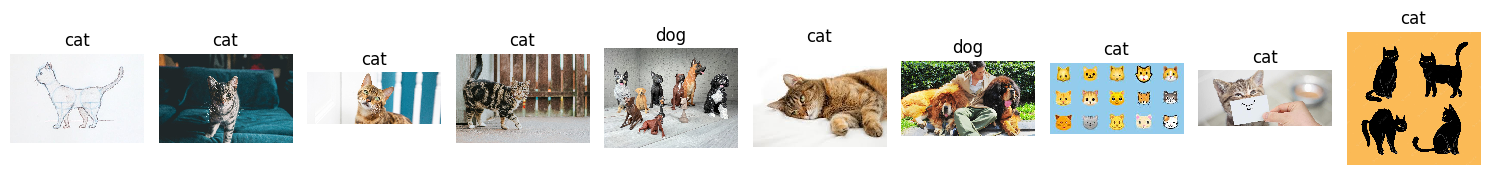

In [15]:
visualize_images(df, num_images=10)

Shape of X: (697, 64, 64, 3)
Shape of y: (697,)


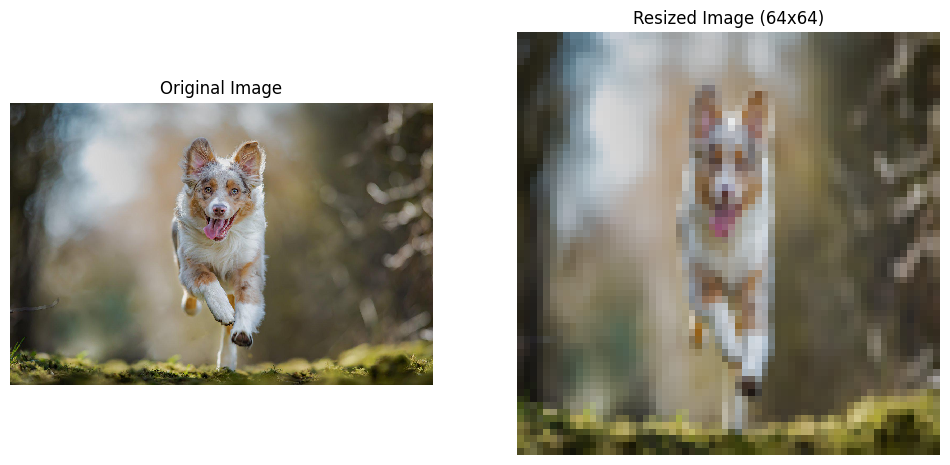

In [16]:
# Mapear categorias para números
category_mapping = {category: idx for idx, category in enumerate(df['category'].unique())}
df['category_label'] = df['category'].map(category_mapping)

# Carregar imagens e suas categorias
def load_images_and_labels(df, directory):
    images = []
    labels = []
    for idx, row in df.iterrows():
        image_path = os.path.join(directory, row['filename'])  # Ajuste aqui para não adicionar a categoria novamente
        image = Image.open(image_path)
        image = image.resize((64, 64))  # Redimensionar para 64x64
        image_array = np.array(image)
        if image_array.ndim == 2:  # Convert grayscale to RGB if necessary
            image_array = np.stack((image_array,)*3, axis=-1)
        images.append(image_array)
        labels.append(row['category_label'])
    return np.array(images), np.array(labels)

# Carregar todas as imagens e rótulos
X, y = load_images_and_labels(df, directory)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Example usage
image_path = os.path.join(directory, df['filename'].iloc[0])
visualize_image_resize(image_path)


In [17]:
# Normalizar os dados
X = X / 255.0

# Dividir os dados em conjuntos de treinamento e teste
train_x_orig, test_x_orig, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

In [18]:
test_y

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0])

In [19]:
# Classes (nomes das categorias)
classes = list(category_mapping.keys())

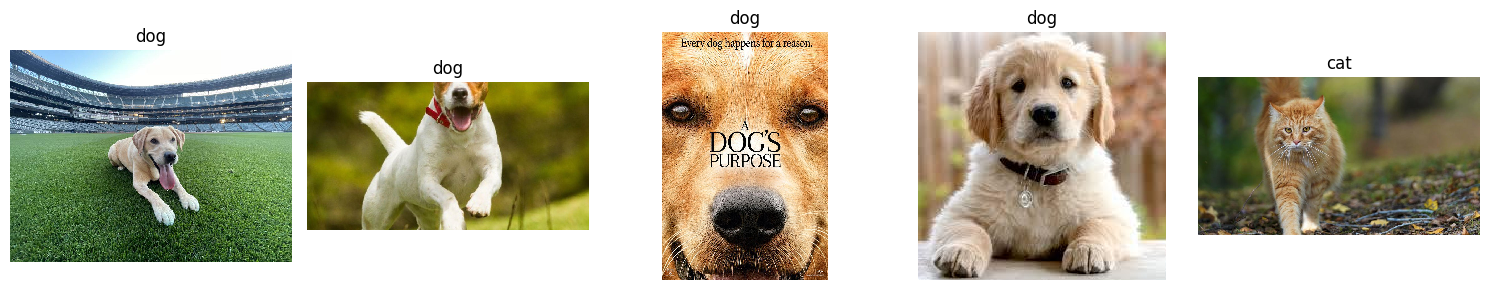

In [20]:
def visualize_images(df, directory, num_images=5):
    sampled_df = df.sample(n=num_images).reset_index(drop=True)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image_path = os.path.join(directory, sampled_df['filename'].iloc[i])
        category = sampled_df['category'].iloc[i]
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(category)
    plt.tight_layout()
    plt.show()

visualize_images(df, directory, num_images=5)

In [21]:
def load_data():
    import h5py
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [22]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<center><img src="images/imvectorkiank.png" style="width:450px;height:300px;"></center>
<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [23]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


**Note**:
$12,288$ equals $64 \times 64 \times 3$, which is the size of one reshaped image vector.

## Model Architecture

You're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

We'll compare the performance of these models, and try out some different values for $L$. 

### 2-layer Neural Network

The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.

<u><b>Detailed Architecture</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.


### L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID

<u><b>Detailed Architecture</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.



### General Methodology

As usual, you'll follow the Deep Learning methodology to build the model:

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

Now go ahead and implement those two models!

In [24]:
### CONSTANTS DEFINING THE MODEL ####
n_x = train_x.shape[0]     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
lr = 0.01

In [25]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters([n_x, n_h, n_y])
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Reshape Y if necessary
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
        
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        # print(X.shape)
        # print(A1.shape)
        # print(A2.shape)
        # print(Y.shape)
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6429673956634753
Cost after iteration 200: 0.6139330587122018
Cost after iteration 300: 0.5603909238662337
Cost after iteration 400: 0.5030563524628465
Cost after iteration 500: 0.4698443892342187
Cost after iteration 600: 0.4355621445123249
Cost after iteration 700: 0.40986977972092914
Cost after iteration 800: 0.3703324586925943
Cost after iteration 900: 0.280125498138903
Cost after iteration 1000: 0.2965487848882415
Cost after iteration 1100: 0.19625387983520973
Cost after iteration 1200: 0.35529332447208767
Cost after iteration 1300: 0.1511707317335539
Cost after iteration 1400: 0.1282205350263976
Cost after iteration 1500: 0.10367329243705369
Cost after iteration 1600: 0.09337081956364973
Cost after iteration 1700: 0.08626919003764873
Cost after iteration 1800: 0.06430869400356981
Cost after iteration 1900: 0.055478150497233904
Cost after iteration 2000: 0.04719098356053281
Cost after iteration 2100: 0.040788815

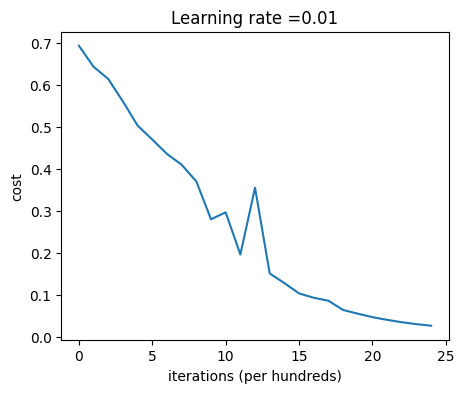

In [26]:
lr = 0.01
parameters, costs = two_layer_model(train_x,
                                    train_y,
                                    layers_dims = (n_x, n_h, n_y),
                                    learning_rate = lr,
                                    num_iterations = 2500,
                                    print_cost=True)
plot_costs(costs, learning_rate = lr)

In [27]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


In [28]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [29]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [40]:
print_mislabeled_images(classes, test_x, test_y, parameters)

TypeError: unsupported operand type(s) for +: 'dict' and 'int'

In [38]:
train_x.shape[0]

12288

In [30]:
### CONSTANTS ###
layers_dims = [train_x.shape[0], 20, 7, 5, 1] #  4-layer model

In [31]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters(layers_dims)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Reshape Y if necessary
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

Cost after iteration 0: 0.6931489045172448
Cost after iteration 100: 0.6780101696342274
Cost after iteration 200: 0.6675987898426479
Cost after iteration 300: 0.660420798699724
Cost after iteration 400: 0.6554567864060155
Cost after iteration 500: 0.6520125406245427
Cost after iteration 600: 0.6496150308724233
Cost after iteration 700: 0.647941085403567
Cost after iteration 800: 0.6467691149981919
Cost after iteration 900: 0.6459465764921428
Cost after iteration 1000: 0.6453680393441446
Cost after iteration 1100: 0.644960357668406
Cost after iteration 1200: 0.6446726073384453
Cost after iteration 1300: 0.6444692233335174
Cost after iteration 1400: 0.644325297953708
Cost after iteration 1500: 0.6442233444846135
Cost after iteration 1600: 0.6441510599798367
Cost after iteration 1700: 0.6440997725849131
Cost after iteration 1800: 0.6440633601309057
Cost after iteration 1900: 0.6440374945734718
Cost after iteration 2000: 0.6440191126459915
Cost after iteration 2100: 0.6440060440869555
Cost

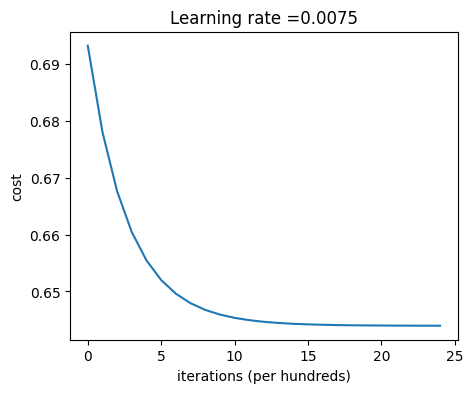

In [39]:
parameters, costs = L_layer_model(train_x,
                                  train_y,
                                  layers_dims,
                                  learning_rate = 0.0075,
                                  num_iterations = 2500,
                                  print_cost = True)

plot_costs(costs, learning_rate=0.0075)

In [33]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [34]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001
